In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import accuracy_score, classification_report


## Reading in the data and getting and overview

In [2]:
# Starting with 10k observations that have NA values filled from KNN imputation
df0 = pd.read_csv('na_filled_df.csv')
df0 = df0.sample(n=35000, random_state=2025)
df = df0
df.shape

(35000, 81)

In [3]:
print(df.head())
df.columns

       activity_year  derived_msa-md  county_code  census_tract  action_taken  \
47390         2019.0         19740.0       8005.0  8.005006e+09           1.0   
38566         2019.0             0.0      60195.0  6.019502e+10           5.0   
32814         2019.0         99999.0      55115.0  5.511510e+10           1.0   
41393         2019.0         46340.0      48423.0  4.842300e+10           4.0   
12564         2019.0         99999.0      27115.0  2.711595e+10           6.0   

       purchaser_type  preapproval  loan_type  loan_purpose  lien_status  ...  \
47390            71.0          2.0        1.0           1.0          1.0  ...   
38566             0.0          2.0        2.0           1.0          1.0  ...   
32814             0.0          2.0        1.0          32.0          1.0  ...   
41393             0.0          2.0        1.0          32.0          1.0  ...   
12564             2.0          2.0        3.0           1.0          1.0  ...   

       derived_loan_produc

Index(['activity_year', 'derived_msa-md', 'county_code', 'census_tract',
       'action_taken', 'purchaser_type', 'preapproval', 'loan_type',
       'loan_purpose', 'lien_status', 'reverse_mortgage',
       'open-end_line_of_credit', 'business_or_commercial_purpose',
       'loan_amount', 'loan_to_value_ratio', 'interest_rate', 'rate_spread',
       'hoepa_status', 'total_loan_costs', 'origination_charges',
       'discount_points', 'lender_credits', 'loan_term',
       'prepayment_penalty_term', 'intro_rate_period', 'negative_amortization',
       'interest_only_payment', 'balloon_payment',
       'other_nonamortizing_features', 'property_value', 'construction_method',
       'occupancy_type', 'manufactured_home_secured_property_type',
       'manufactured_home_land_property_interest', 'income',
       'debt_to_income_ratio', 'applicant_credit_score_type',
       'co-applicant_credit_score_type', 'applicant_ethnicity-1',
       'applicant_ethnicity-2', 'co-applicant_ethnicity-1',
    

action_taken
1.0    53.288571
3.0    14.080000
6.0    13.142857
4.0    12.297143
5.0     4.060000
2.0     2.194286
8.0     0.482857
7.0     0.454286
Name: count, dtype: float64


c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='action_taken', ylabel='count'>

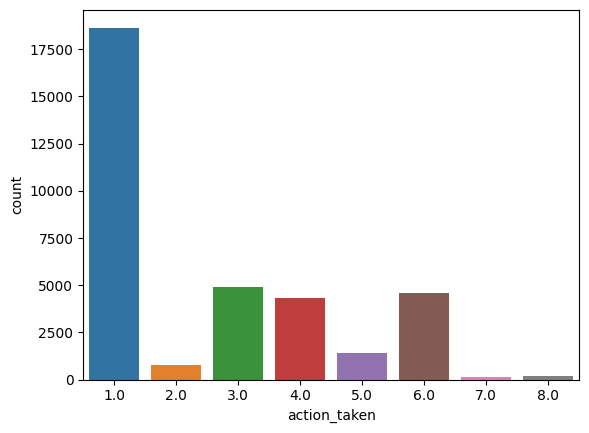

In [4]:
# Looking at the percentage of each action type
print(df['action_taken'].value_counts()/len(df)*100)
sns.countplot(x='action_taken', data=df)

In [5]:
# Converting target variable to binary
df['action_taken'] = df['action_taken'].apply(lambda x: 1 if x in [1,2,6] else 0)

****

### Data cleaning and feature selection

In [6]:
# Dropping denial reason because it perfectly predicts approval or denial 
# Dropping lei because it is not feasible to make every financial institution into a dummy variable
df = df.drop(columns=['denial_reason-1', 'denial_reason-2', 'lei'])

In [7]:
# Finding categorical variables
string_columns = df.select_dtypes(include=['object']).columns
string_df = df[string_columns]
print(string_columns)

Index(['state_code', 'conforming_loan_limit', 'derived_loan_product_type',
       'derived_dwelling_category', 'derived_ethnicity', 'derived_race',
       'derived_sex', 'total_units', 'applicant_age', 'co-applicant_age',
       'applicant_age_above_62', 'co-applicant_age_above_62'],
      dtype='object')


In [8]:
# Seeing how many unique values each category has
unique_counts = {}

for column in string_columns:
    unique_counts[column] = df[column].nunique()

unique_counts

{'state_code': 52,
 'conforming_loan_limit': 3,
 'derived_loan_product_type': 6,
 'derived_dwelling_category': 3,
 'derived_ethnicity': 5,
 'derived_race': 9,
 'derived_sex': 4,
 'total_units': 9,
 'applicant_age': 8,
 'co-applicant_age': 9,
 'applicant_age_above_62': 2,
 'co-applicant_age_above_62': 2}

In [9]:
# Making sure these are strings and not mixed data types
df['applicant_sex'] = df['applicant_sex'].astype(str)
df['applicant_age_above_62'] = df['applicant_age_above_62'].astype(str)
df['derived_race'] = df['derived_race'].astype(str)
df_dummies = pd.get_dummies(df, columns=string_columns, drop_first=True)
df_dummies.shape

(35000, 167)

## Building a logistic regression model

In [10]:
# Splitting the data
y = df_dummies['action_taken']
X = df_dummies.drop(columns='action_taken')
# Inlcuding the sensitive features also to use later in Fairlearn
sensitive_features_data = df[['applicant_sex', 'applicant_age_above_62', 'derived_race']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2023)
sensitive_features_train, sensitive_features_test = train_test_split(sensitive_features_data, test_size=0.25, random_state=2023)

Confusion Matrix:


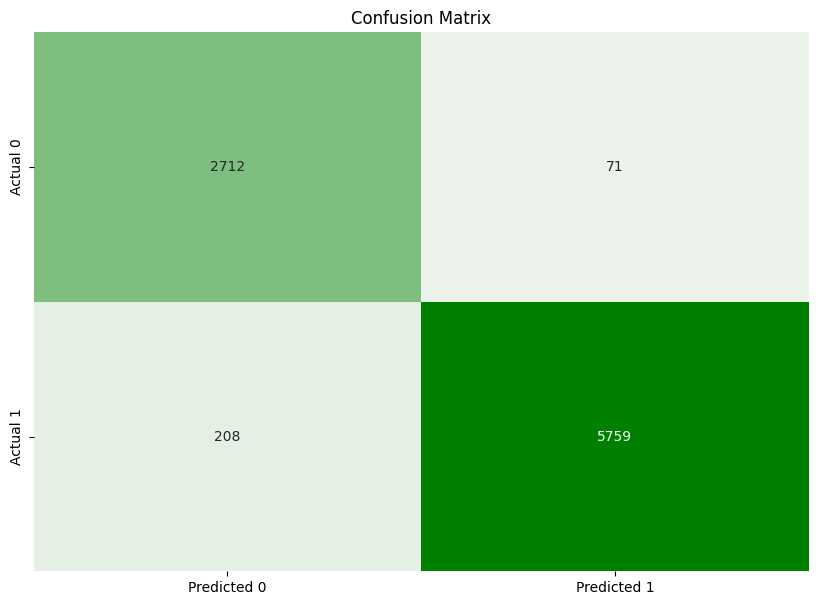

In [11]:
# Building the random forest model
rf0 = RandomForestClassifier(n_estimators=100, random_state=2023)
rf0.fit(X_train, y_train)

# Generating predictions and displaying the confusion matrix
y_pred = rf0.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
# Create a custom color map
cmap = sns.light_palette("green", as_cmap=True)

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.title('Confusion Matrix')
plt.show()

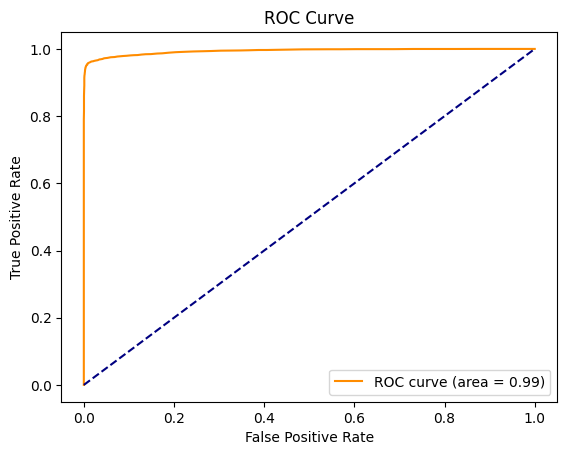

In [12]:
# Plotting the ROC curve
y_prob = rf0.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()  

****

## Looking into metrics with Microsoft Fairlearn

In [13]:
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import selection_rate

In [14]:
sensitive_features_test

,applicant_sex,applicant_age_above_62,derived_race
43867,2.0,No,White
27739,1.0,No,White
10689,2.0,No,White
687,2.0,No,White
16423,2.0,No,White
...,...,...,...
38764,4.0,nan,Race Not Available
13546,2.0,No,White
12498,1.0,No,White
45317,3.0,No,Race Not Available


In [15]:
# Accuracy by race
mf = MetricFrame(metrics=accuracy_score, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features_test['derived_race'])
print(mf.overall)
mf.by_group

0.9681142857142857


c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\fairlearn\metrics\_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)
c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\fairlearn\metrics\_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)
c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\fairlearn\metrics\_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)


derived_race
2 or more minority races                     0.900000
American Indian or Alaska Native             1.000000
Asian                                        0.965675
Black or African American                    0.967684
Joint                                        0.971429
Native Hawaiian or Other Pacific Islander    1.000000
Race Not Available                           0.975369
White                                        0.965335
Name: accuracy_score, dtype: float64

In [16]:
# Selection rate is the percentage of the population that is labeled '1'
sr = MetricFrame(metrics=selection_rate, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features_test['derived_race'])
print(sr.overall)
sr.by_group

0.6662857142857143


c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\fairlearn\metrics\_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)
c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\fairlearn\metrics\_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)
c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\fairlearn\metrics\_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)


derived_race
2 or more minority races                     0.400000
American Indian or Alaska Native             0.500000
Asian                                        0.645309
Black or African American                    0.509874
Joint                                        0.617143
Native Hawaiian or Other Pacific Islander    0.500000
Race Not Available                           0.739409
White                                        0.660646
Name: selection_rate, dtype: float64

In [17]:
# Manually defining FPR and FNR
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Define False Positive Rate
def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn)

# Define False Negative Rate
def false_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn / (fn + tp)

# Define Selection Rate
def selection_rate(y_true, y_pred):
    return sum(y_pred) / len(y_pred)

# Define Count (this is simply the length of y_pred)
def count(y_true, y_pred):
    return len(y_pred)

c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\fairlearn\metrics\_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)
c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\fairlearn\metrics\_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)
c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\fairlearn\metrics\_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)


array([[<Axes: title={'center': 'accuracy'}, xlabel='applicant_sex'>,
        <Axes: title={'center': 'precision'}, xlabel='applicant_sex'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='applicant_sex'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='applicant_sex'>,
        <Axes: title={'center': 'selection rate'}, xlabel='applicant_sex'>,
        <Axes: title={'center': 'count'}, xlabel='applicant_sex'>],
       [<Axes: xlabel='applicant_sex'>, <Axes: xlabel='applicant_sex'>,
        <Axes: xlabel='applicant_sex'>]], dtype=object)

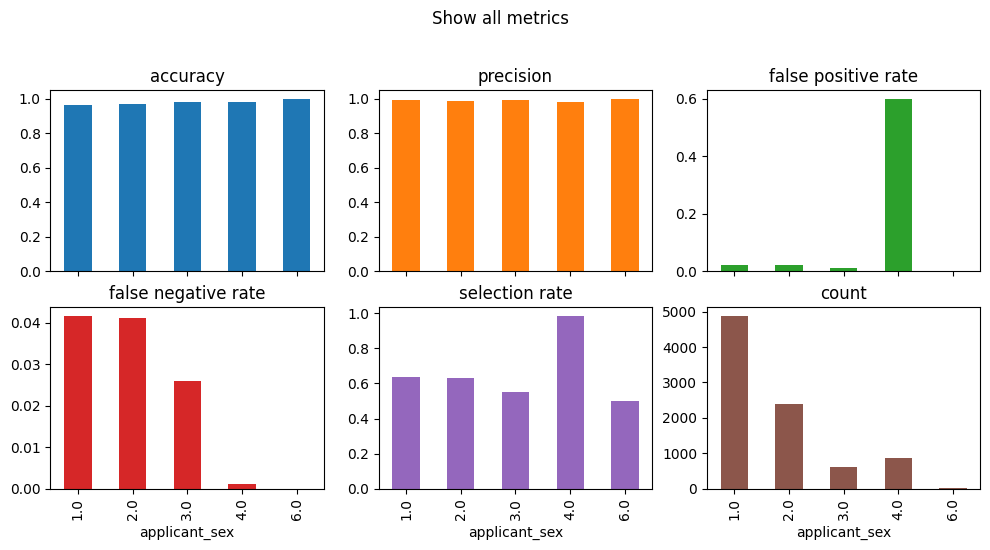

In [24]:
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
    "count": count,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features_test['applicant_sex'])

metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\fairlearn\metrics\_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)
c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\fairlearn\metrics\_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)
c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\fairlearn\metrics\_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)


array([[<Axes: title={'center': 'accuracy'}, xlabel='derived_race'>,
        <Axes: title={'center': 'precision'}, xlabel='derived_race'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='derived_race'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='derived_race'>,
        <Axes: title={'center': 'selection rate'}, xlabel='derived_race'>,
        <Axes: title={'center': 'count'}, xlabel='derived_race'>],
       [<Axes: xlabel='derived_race'>, <Axes: xlabel='derived_race'>,
        <Axes: xlabel='derived_race'>]], dtype=object)

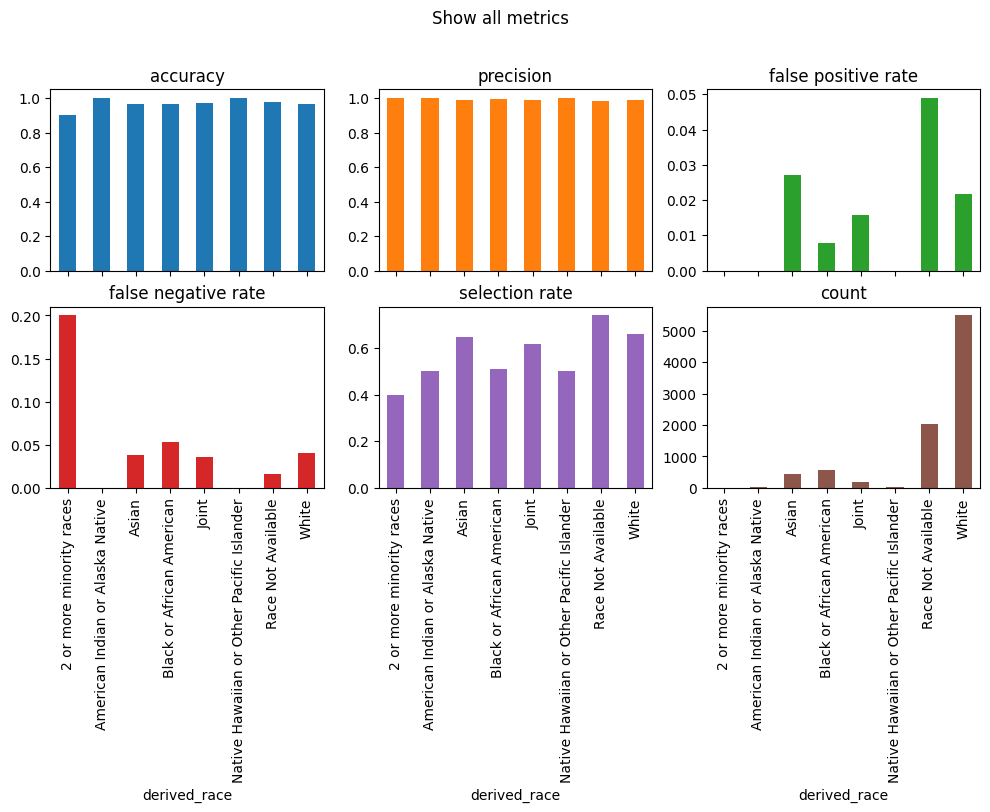

In [18]:
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
    "count": count,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features_test['derived_race'])

metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\fairlearn\metrics\_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)
c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\fairlearn\metrics\_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)
c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\fairlearn\metrics\_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)


array([[<Axes: title={'center': 'accuracy'}, xlabel='applicant_age_above_62'>,
        <Axes: title={'center': 'precision'}, xlabel='applicant_age_above_62'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='applicant_age_above_62'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='applicant_age_above_62'>,
        <Axes: title={'center': 'selection rate'}, xlabel='applicant_age_above_62'>,
        <Axes: title={'center': 'count'}, xlabel='applicant_age_above_62'>],
       [<Axes: xlabel='applicant_age_above_62'>,
        <Axes: xlabel='applicant_age_above_62'>,
        <Axes: xlabel='applicant_age_above_62'>]], dtype=object)

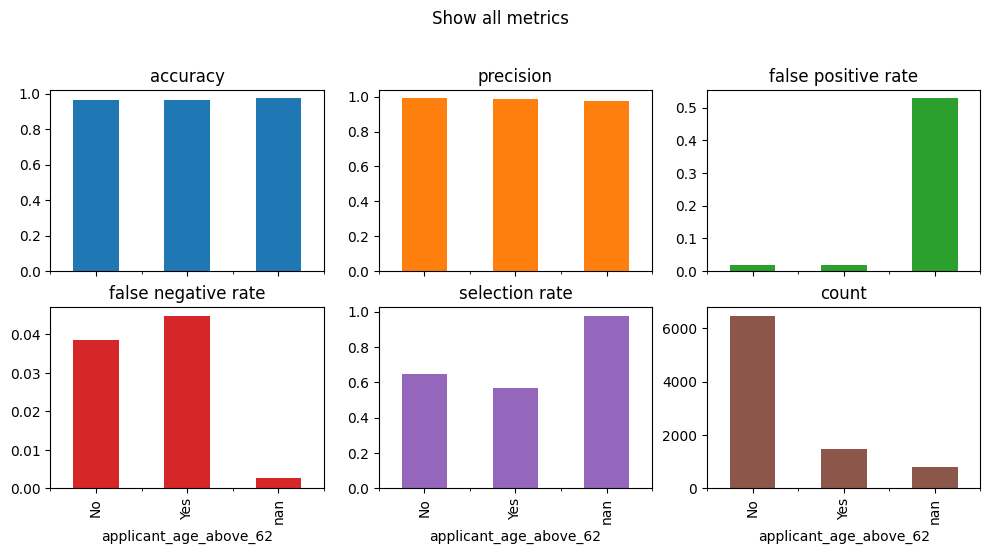

In [19]:
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
    "count": count,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features_test['applicant_age_above_62'])

metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

derived_race
White                                        62.808571
Race Not Available                           23.125714
Black or African American                     6.371429
Asian                                         5.028571
Joint                                         1.811429
American Indian or Alaska Native              0.457143
Native Hawaiian or Other Pacific Islander     0.237143
2 or more minority races                      0.140000
Free Form Text Only                           0.020000
Name: count, dtype: float64


c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='derived_race', ylabel='count'>

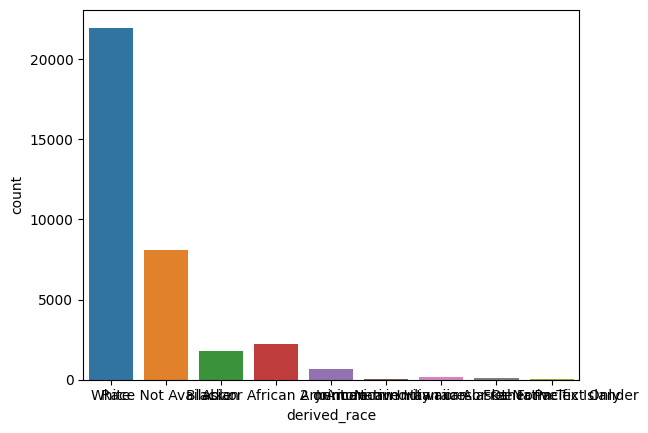

In [20]:
# Getting errors for race and sex metrics. It seems that some groups are too small and causing errors.
print(df['derived_race'].value_counts()/len(df)*100)
sns.countplot(x='derived_race', data=df)

applicant_sex
1.0    55.740000
2.0    27.548571
4.0     9.762857
3.0     6.894286
6.0     0.054286
Name: count, dtype: float64


c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Emerson\Desktop\MSBA\Capstone\Code\MSBA_Capstone_Saxa7\capstone_env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='applicant_sex', ylabel='count'>

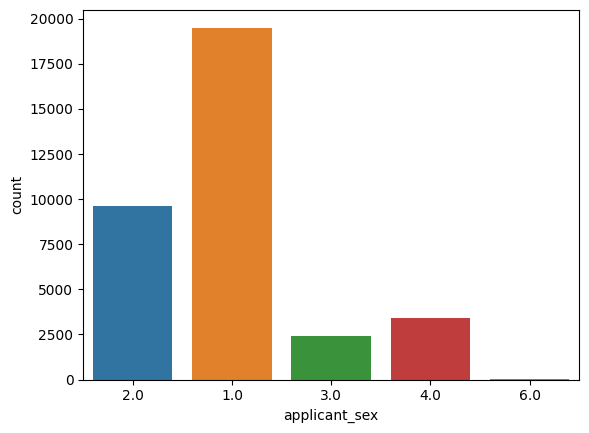

In [21]:
print(df['applicant_sex'].value_counts()/len(df)*100)
sns.countplot(x='applicant_sex', data=df)

In [ ]:
# In race 'free form text' and in sex '6' the categories are too small. This means that if they only appear in one class you cannot generate a confusion matrix which causes issues. Consider dropping these categories.